In [27]:
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from io import BytesIO
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from collections import Counter
import IPython.display as display

sn.set()

from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier # XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [28]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

In [29]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))
    
    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }   

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299,1])        
        image=image.numpy()
        image=cv2.resize(image,(100,100))
#         image=cv2.merge([image,image,image])        
        #plt.imshow(image)
        images.append(image)
        labels.append(image_features['label_normal'].numpy())

In [30]:
filenames=['../input/ddsm-mammography/training10_0/training10_0.tfrecords',
          '../input/ddsm-mammography/training10_1/training10_1.tfrecords',
          '../input/ddsm-mammography/training10_2/training10_2.tfrecords',
          '../input/ddsm-mammography/training10_3/training10_3.tfrecords',
          '../input/ddsm-mammography/training10_4/training10_4.tfrecords']

for file in filenames:
    read_data(file)
    
print(len(images))
print(len(labels))

Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
55885
55885


In [31]:
X=np.array(images)
y=np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021,shuffle=True,stratify=y)
(a,b,c)=x_train.shape 
x_train = np.reshape(x_train, (a, b, c, 1))
(a, b, c)=x_test.shape
x_test = np.reshape(x_test, (a, b, c, 1))

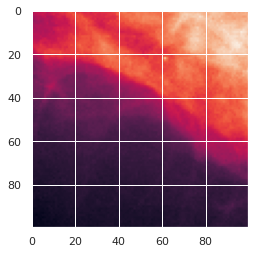

In [32]:
plt.imshow(x_train[0])

In [33]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

print(x_train[0].shape)

(100, 100, 1)


In [34]:
rows, cols,color = x_train[0].shape
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='valid', strides=(1, 1),input_shape=(rows,cols,1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2),strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2),strides=2))

model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2),strides=2))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
activation_10 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 49, 49, 64)        18496     
_________________________________________________________________
activation_11 (Activation)   (None, 49, 49, 64)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 64)       

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=6,restore_best_weights=True, verbose=1)

In [36]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=40, batch_size=64,callbacks=[es])
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

#print(model.predict(x_test))
#model.save('breast_cance_model.h5')

# save_dictionary('history1.dat', history.history)

Epoch 1/40
559/559 [==============================] - 8s 13ms/step - loss: 0.5801 - accuracy: 0.8577 - val_loss: 0.2983 - val_accuracy: 0.8910
Epoch 2/40
559/559 [==============================] - 7s 12ms/step - loss: 0.2873 - accuracy: 0.8822 - val_loss: 0.2571 - val_accuracy: 0.8952
Epoch 3/40
559/559 [==============================] - 7s 12ms/step - loss: 0.2662 - accuracy: 0.8938 - val_loss: 0.2429 - val_accuracy: 0.8945
Epoch 4/40
559/559 [==============================] - 7s 12ms/step - loss: 0.2361 - accuracy: 0.9019 - val_loss: 0.2788 - val_accuracy: 0.8808
Epoch 5/40
559/559 [==============================] - 7s 12ms/step - loss: 0.2312 - accuracy: 0.9065 - val_loss: 0.2330 - val_accuracy: 0.8988
Epoch 6/40
559/559 [==============================] - 7s 13ms/step - loss: 0.2284 - accuracy: 0.9068 - val_loss: 0.2303 - val_accuracy: 0.9128
Epoch 7/40
559/559 [==============================] - 7s 12ms/step - loss: 0.2209 - accuracy: 0.9068 - val_loss: 0.2658 - val_accuracy: 0.8876

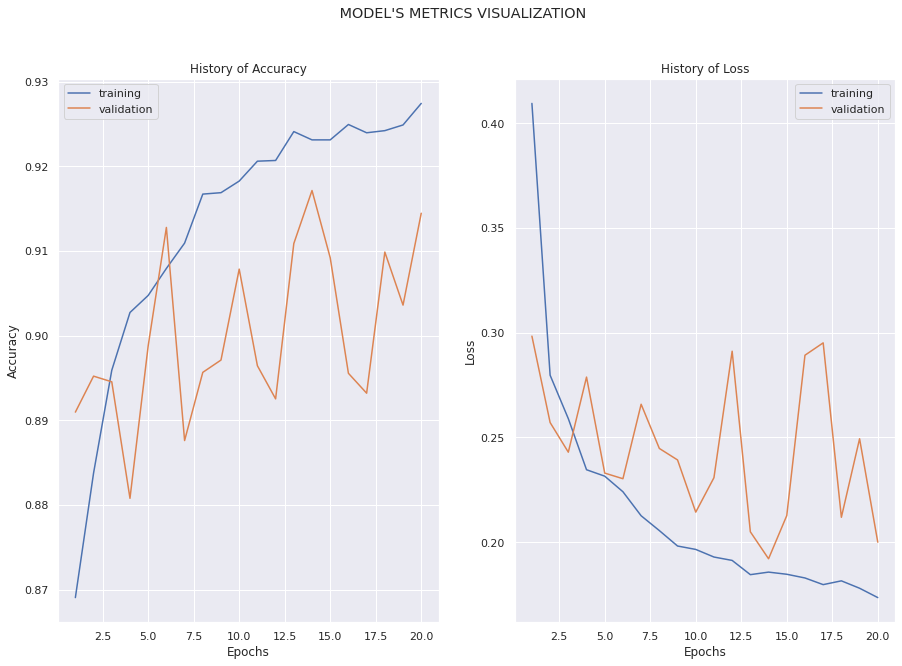

In [37]:
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [38]:
y_pred=model.predict_classes(x_test)
y_pred_prb=model.predict_proba(x_test)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [39]:
target=["0","1"]
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, y_pred_prb,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred,target_names=target))

Accuracy: 0.921
Precision: 0.9195
Recall: 0.921
F1 Score: 0.909
ROC AUC Score: 0.9448
Cohen Kappa Score: 0.5562
		Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.96      9719
           1       0.90      0.44      0.59      1458

    accuracy                           0.92     11177
   macro avg       0.91      0.72      0.78     11177
weighted avg       0.92      0.92      0.91     11177

